## Import Libraries

In [1]:
import cv2 
import pickle
import matplotlib.pyplot as plt

In [3]:
cv2.imread("data/images/taj1.jpg",0)

array([[ 95,  96,  96, ..., 109, 111, 112],
       [ 95,  96,  97, ..., 109, 111, 112],
       [ 96,  96,  97, ..., 109, 110, 111],
       ...,
       [ 89,  85,  90, ...,  60,  55,  50],
       [ 75,  72,  83, ...,  80,  69,  64],
       [ 68,  69,  81, ...,  94,  80,  76]], dtype=uint8)

### Resize Images function

In [2]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

## Generate Keypoint and Descriptors

### Prepare list of images

In [3]:
# Define a list of images the way you like

imageList = ["taj1.jpg","taj2.jpg","eiffel1.jpg","eiffel2.jpg","liberty1.jpg","liberty2.jpg","robert1.jpg","tom1.jpg","ironman1.jpg","ironman2.jpg","ironman3.jpg","darkknight1.jpg","darkknight2.jpg","book1.jpg","book2.jpg"]

In [4]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    imagePath = "data/images/" + str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [ ]:
# # Gray-scale images improve speed

# imageBW = []
# for image in images:
#     imageBW.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

### Choose between opencv's SIFT and open source SIFT implementation<br>

In [5]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [28]:
# # Using custom (rmislam/PythonSIFT) sift implementation
# # Comparitively slower than opencv's implementation
# # but source code is present in repo, hence easily modifiable

import pysift

def computeSIFT(image):
    return pysift.computeKeypointsAndDescriptors(image)

### The following is the main function to generate the keypoints and descriptors<br>
When using SIFT, this takes a lot of time to compute.<br>
Thus, it is suggested, you store the values once computed<br>
(Code for storing is written below)

In [6]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Number of keypoints is: ",)
    print("  Keypoint is: ", keypointTemp[0].pt)
    print("  Descriptor shape is: ", descriptorTemp.shape)
    print("  Ending for image: " + imageList[i])


Starting for image: taj1.jpg
  Number of keypoints is: 
  Keypoint is:  (2.459742546081543, 495.8432312011719)
  Descriptor shape is:  (2932, 128)
  Ending for image: taj1.jpg
Starting for image: taj2.jpg
  Number of keypoints is: 
  Keypoint is:  (2.661740303039551, 467.78387451171875)
  Descriptor shape is:  (3575, 128)
  Ending for image: taj2.jpg
Starting for image: eiffel1.jpg
  Number of keypoints is: 
  Keypoint is:  (2.2928431034088135, 780.3554077148438)
  Descriptor shape is:  (1910, 128)
  Ending for image: eiffel1.jpg
Starting for image: eiffel2.jpg
  Number of keypoints is: 
  Keypoint is:  (2.711444139480591, 630.932373046875)
  Descriptor shape is:  (3057, 128)
  Ending for image: eiffel2.jpg
Starting for image: liberty1.jpg
  Number of keypoints is: 
  Keypoint is:  (2.8466455936431885, 988.4599609375)
  Descriptor shape is:  (2176, 128)
  Ending for image: liberty1.jpg
Starting for image: liberty2.jpg
  Number of keypoints is: 
  Keypoint is:  (4.390732765197754, 385.9

### Store Keypoints and Descriptors for future use

In [7]:
for i,keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)    


In [8]:
for i,descriptor in enumerate(descriptors):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)


## Prepare for fetching results

### Fetch Keypoints and Descriptors from stored files

In [9]:
def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

In [10]:
def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

### Calculate Results for any pair

In [11]:
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(len(matches),len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
    print(score)
    plt.imshow(plot)
    plt.axis('off')
    plt.show()

In [12]:
def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread("data/images/" + imageList[i]))
    image2 = imageResizeTest(cv2.imread("data/images/" + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

### Basic Scoring metric
A score greater than 10 means very good

In [13]:
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

### Use this part of code for brute force matching

In [37]:
# bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# def calculateMatches(descriptor1,descriptor2):
#     matches = bf.match(descriptor1,descriptor2)
#     matches = sorted(matches, key = lambda x:x.distance)
#     return matches

In [ ]:
# def getPlot(image1,image2,keypoint1,keypoint2,matches):
#     matchPlot = cv2.drawMatches(image1, keypoint1, image2, keypoint2, matches[:50], image2, flags=2)
#     return matchPlot

### Use this part of code for knn matching

In [14]:
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

In [ ]:
# Use this if you want faster results and can give up some accuracy
# bf = cv2.BFMatcher()
# def calculateMatches(des1,des2):
#     matches = bf.knnMatch(des1,des2,k=2)
#     topResults = []
#     for m,n in matches:
#         if m.distance < 0.7*n.distance:
#             topResults.append([m])
#     return topResults

In [15]:
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [-1,-1,-1],
        flags=2
    )
    return matchPlot

## Fetch Results

### Sample Results

220 2236 2342 2236 2342
9.838998211091235


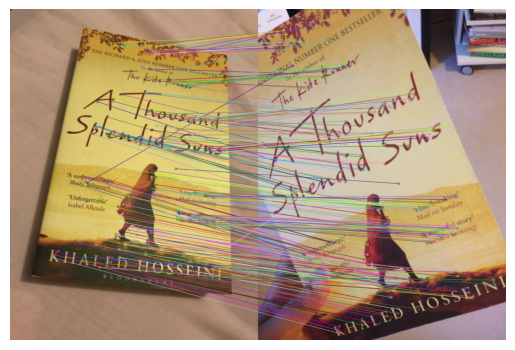

In [18]:
calculateResultsFor(11,12)
